In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
coal_data = pd.read_csv("../_data_process/_all_temporal_coal_indicators.csv")
gas_data = pd.read_csv("../_data_process/_all_temporal_gas_indicators.csv")
re_data = pd.read_csv("../_data_process/_all_temporal_RE_capacity_GEM.csv")
crosswalk = pd.read_excel("../_data_process/country_names.xlsx",sheet_name="crosswalk")

In [5]:
combined_data = pd.merge(coal_data,crosswalk[["GEM_Name","Country Code"]],left_on=["Country"],right_on=["GEM_Name"])
combined_data = pd.merge(combined_data,gas_data,left_on=["Country Code","Year"],right_on=["Country Code","year"],how="left")
combined_data = combined_data.drop(columns=["year","Country","GEM_Name"])
combined_data = pd.merge(combined_data,re_data, left_on=["Country Code","Year"],right_on=["Country Code","year"],how="left")
combined_data = combined_data.drop(columns=["year","Wind_GW","Solar_GW"])
combined_data = combined_data.set_index(["Country Code","Year"]).reset_index()
combined_data

,Country Code,Year,Coal_Current_MW,Coal_AnnualMtCO2,Coal_start_year,Coal_Peak_MW,Coal_Ret_MW,Coal_EarlyRet_MW,Coal_Tran_MW,Coal_duration_year,...,Gas_duration_year,Gas_Peak_MW,Gas_Ret_MW,Gas_EarlyRet_MW,Gas_Share_Ret,Gas_Share_EarlyRet,Gas_Share_PhasedOut,Gas_logCurrent_MW,Wind_MW,Solar_MW
0,DEU,1927,36.0,0.2,1927.0,36.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,DEU,1928,36.0,0.2,1927.0,36.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,DEU,1929,36.0,0.2,1927.0,36.0,0.0,0.0,0.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,DEU,1930,36.0,0.2,1927.0,36.0,0.0,0.0,0.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,DEU,1931,36.0,0.2,1927.0,36.0,0.0,0.0,0.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3878,BRN,2021,220.0,1.2,2019.0,220.0,0.0,0.0,0.0,2.0,...,13.0,212.0,0.0,0.0,0.0,0.0,0.0,5.356586,NaN,NaN
3879,BRN,2022,220.0,1.2,2019.0,220.0,0.0,0.0,0.0,3.0,...,14.0,212.0,0.0,0.0,0.0,0.0,0.0,5.356586,NaN,NaN
3880,ARE,2020,600.0,2.3,2020.0,600.0,0.0,0.0,0.0,0.0,...,41.0,38467.0,0.0,0.0,0.0,0.0,0.0,10.557556,0.0,2300.0
3881,ARE,2021,1200.0,4.6,2020.0,1200.0,0.0,0.0,0.0,1.0,...,42.0,40652.0,0.0,0.0,0.0,0.0,0.0,10.612803,0.0,2899.0


In [6]:
combined_data.columns

Index(['Country Code', 'Year', 'Coal_Current_MW', 'Coal_AnnualMtCO2',
       'Coal_start_year', 'Coal_Peak_MW', 'Coal_Ret_MW', 'Coal_EarlyRet_MW',
       'Coal_Tran_MW', 'Coal_duration_year', 'Coal_Share_Ret',
       'Coal_Share_EarlyRet', 'Coal_Share_Tran', 'Coal_Share_PhasedOut',
       'Coal_logCurrent_MW', 'Gas_Current_MW', 'Gas_start_year',
       'Gas_duration_year', 'Gas_Peak_MW', 'Gas_Ret_MW', 'Gas_EarlyRet_MW',
       'Gas_Share_Ret', 'Gas_Share_EarlyRet', 'Gas_Share_PhasedOut',
       'Gas_logCurrent_MW', 'Wind_MW', 'Solar_MW'],
      dtype='object')

In [7]:
decline_countries = combined_data[combined_data['Coal_Share_PhasedOut']>0]["Country Code"].unique()
len(decline_countries)

40

In [102]:
for cntry in decline_countries:
    cntry_data = combined_data[combined_data["Country Code"]==cntry]
    if cntry_data["Coal_Peak_MW"].max()>1000:
        cntry_data_coal_phaseout = cntry_data[cntry_data['Coal_Share_PhasedOut']>0]
        phseout_index = cntry_data_coal_phaseout.index
        selected_data = cntry_data.loc[phseout_index.min()-1:phseout_index.max()]
        if len(selected_data) >5 and cntry_data_coal_phaseout["Year"].max() == 2022:
            initial_gas = selected_data["Gas_Current_MW"].iloc[0]
            selected_data["Gas_Growth_MW"] = selected_data["Gas_Current_MW"] - initial_gas
            selected_data["Gas_FuelSwitch"] = selected_data["Gas_Growth_MW"]/selected_data["Coal_Peak_MW"]*100
            selected_data["Gas_Substitution"] = selected_data["Gas_Growth_MW"]/(selected_data["Coal_Share_PhasedOut"]/100*selected_data["Coal_Peak_MW"])
            initial_wind = selected_data["Wind_MW"].iloc[0]
            selected_data["Wind_Growth_MW"] = selected_data["Wind_MW"] - initial_wind
            selected_data["Wind_FuelSwitch"] = selected_data["Wind_Growth_MW"]/selected_data["Coal_Peak_MW"]*100
            selected_data["Wind_Substitution"] = selected_data["Wind_Growth_MW"]/(selected_data["Coal_Share_PhasedOut"]/100*selected_data["Coal_Peak_MW"])
            initial_solar = selected_data["Solar_MW"].iloc[0]
            selected_data["Solar_Growth_MW"] = selected_data["Solar_MW"] - initial_solar
            selected_data["Solar_FuelSwitch"] = selected_data["Solar_Growth_MW"]/selected_data["Coal_Peak_MW"]*100
            selected_data["Solar_Substitution"] = selected_data["Solar_Growth_MW"]/(selected_data["Coal_Share_PhasedOut"]/100*selected_data["Coal_Peak_MW"])
            if cntry == decline_countries[0]:
                selected_data_all = selected_data
            else:
                selected_data_all = pd.concat([selected_data_all,selected_data])

selected_data_all["Gas_FuelSwitch"] = selected_data_all["Gas_FuelSwitch"].fillna(0)
selected_data_all["Wind_FuelSwitch"] = selected_data_all["Wind_FuelSwitch"].fillna(0)
selected_data_all["Solar_FuelSwitch"] = selected_data_all["Solar_FuelSwitch"].fillna(0)
selected_data_all["Coal_Phaseout_MW"] = selected_data_all["Coal_Current_MW"]*(selected_data_all["Coal_Share_PhasedOut"])
selected_data_all

,Country Code,Year,Coal_Current_MW,Coal_AnnualMtCO2,Coal_start_year,Coal_Peak_MW,Coal_Ret_MW,Coal_EarlyRet_MW,Coal_Tran_MW,Coal_duration_year,...,Gas_Growth_MW,Gas_FuelSwitch,Gas_Substitution,Wind_Growth_MW,Wind_FuelSwitch,Wind_Substitution,Solar_Growth_MW,Solar_FuelSwitch,Solar_Substitution,Coal_Phaseout_MW
73,DEU,2000,52726.6,286.5,1927.0,52726.6,630.0,80.0,300.0,73.0,...,0.0,0.000000,NaN,0.0,0.000000,NaN,0.0,0.000000,NaN,0.000000
74,DEU,2001,52141.6,283.2,1927.0,52726.6,1215.0,405.0,300.0,74.0,...,244.0,0.462765,0.417094,1357.0,2.573654,2.319658,0.0,0.000000,0.000000,57850.944305
75,DEU,2002,52631.6,285.2,1927.0,52726.6,1215.0,405.0,822.0,75.0,...,357.0,0.677078,3.757895,2732.0,5.181445,28.757895,0.0,0.000000,0.000000,9482.883402
76,DEU,2003,52210.6,282.8,1927.0,52726.6,1636.0,526.0,822.0,76.0,...,443.0,0.840183,0.858527,4178.0,7.923894,8.096899,0.0,0.000000,0.000000,51095.025281
77,DEU,2004,52120.6,282.3,1927.0,52726.6,1636.0,526.0,912.0,77.0,...,1010.0,1.915542,1.666667,5285.0,10.023404,8.721122,0.0,0.000000,0.000000,59903.509045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3241,NLD,2018,4837.0,19.7,1981.0,6043.0,1073.0,441.0,1907.0,37.0,...,0.0,0.000000,0.000000,885.0,14.645044,0.733831,129.0,2.134701,0.106965,96531.888135
3242,NLD,2019,4152.0,16.5,1981.0,6043.0,1073.0,441.0,2592.0,38.0,...,144.0,2.382922,0.076150,1117.0,18.484197,0.590693,333.0,5.510508,0.176097,129926.063214
3243,NLD,2020,4152.0,16.5,1981.0,6043.0,1073.0,441.0,2592.0,39.0,...,144.0,2.382922,0.076150,2981.0,49.329803,1.576415,698.3,11.555519,0.369276,129926.063214
3244,NLD,2021,4152.0,16.5,1981.0,6043.0,1073.0,441.0,2592.0,40.0,...,144.0,2.382922,0.076150,4398.0,72.778421,2.325754,991.3,16.404104,0.524220,129926.063214


In [115]:
to_export = pd.merge(combined_data,selected_data_all[["Country Code","Year","Gas_Growth_MW","Gas_FuelSwitch","Gas_Substitution",
                                                    "Wind_Growth_MW","Wind_FuelSwitch","Wind_Substitution",
                                                     "Solar_Growth_MW","Solar_FuelSwitch","Solar_Substitution","Coal_Phaseout_MW"]],
                     left_on=["Country Code","Year"],right_on=["Country Code","Year"],how="left")
to_export.set_index("Country Code").to_csv("../_data_process/combined_coal_gas_indicators.csv")
to_export

,Country Code,Year,Coal_Current_MW,Coal_AnnualMtCO2,Coal_start_year,Coal_Peak_MW,Coal_Ret_MW,Coal_EarlyRet_MW,Coal_Tran_MW,Coal_duration_year,...,Gas_Growth_MW,Gas_FuelSwitch,Gas_Substitution,Wind_Growth_MW,Wind_FuelSwitch,Wind_Substitution,Solar_Growth_MW,Solar_FuelSwitch,Solar_Substitution,Coal_Phaseout_MW
0,DEU,1927,36.0,0.2,1927.0,36.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,DEU,1928,36.0,0.2,1927.0,36.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,DEU,1929,36.0,0.2,1927.0,36.0,0.0,0.0,0.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,DEU,1930,36.0,0.2,1927.0,36.0,0.0,0.0,0.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,DEU,1931,36.0,0.2,1927.0,36.0,0.0,0.0,0.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3878,BRN,2021,220.0,1.2,2019.0,220.0,0.0,0.0,0.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3879,BRN,2022,220.0,1.2,2019.0,220.0,0.0,0.0,0.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3880,ARE,2020,600.0,2.3,2020.0,600.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3881,ARE,2021,1200.0,4.6,2020.0,1200.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### VISUALIZATION

In [79]:
ind_data = selected_data_all.query("Year==2022")
ind_data["All_FuelSwitch"] = ind_data["Gas_FuelSwitch"] + ind_data["Wind_FuelSwitch"] + ind_data["Solar_FuelSwitch"]
ind_data["Gas_FuelSwitchPerc"] = ind_data["Gas_FuelSwitch"]/ind_data["All_FuelSwitch"]
ind_data["Wind_FuelSwitchPerc"] = ind_data["Wind_FuelSwitch"]/ind_data["All_FuelSwitch"]
ind_data["Solar_FuelSwitchPerc"] = ind_data["Solar_FuelSwitch"]/ind_data["All_FuelSwitch"]
ind_data = ind_data.sort_values(by="Gas_FuelSwitch",ascending=False)
ind_data

,Country Code,Year,Coal_Current_MW,Coal_AnnualMtCO2,Coal_start_year,Coal_Peak_MW,Coal_Ret_MW,Coal_EarlyRet_MW,Coal_Tran_MW,Coal_duration_year,...,Wind_Growth_MW,Wind_FuelSwitch,Wind_Substitution,Solar_Growth_MW,Solar_FuelSwitch,Solar_Substitution,All_FuelSwitch,Gas_FuelSwitchPerc,Wind_FuelSwitchPerc,Solar_FuelSwitchPerc
865,ITA,2022,6806.00,33.2,1952.0,9967.0,1085.00,0.0,3109.00,70.0,...,7410.00,74.345340,2.344195,791.0,7.936189,0.250237,429.788301,0.808553,0.172981,0.018465
2062,AUT,2022,0.00,0.0,1962.0,1993.0,1681.00,522.0,312.00,60.0,...,2762.00,138.585048,1.385850,24.0,1.204215,0.012042,334.520823,0.582121,0.414279,0.003600
1680,UZB,2022,2493.00,14.0,1957.0,2584.0,241.00,0.0,0.00,65.0,...,0.00,0.000000,0.000000,200.0,7.739938,2.197802,169.659443,0.954380,0.000000,0.045620
2481,PRT,2022,0.00,0.0,1964.0,2028.0,1296.00,0.0,732.00,58.0,...,4916.00,242.406312,2.424063,1112.8,54.871795,0.548718,456.005917,0.348083,0.531586,0.120331
2598,BRA,2022,3177.00,15.7,1965.0,3278.0,518.00,0.0,0.00,57.0,...,11154.00,340.268456,110.435644,5104.0,155.704698,50.534653,640.085418,0.225145,0.531599,0.243256
183,USA,2022,212041.66,1077.7,1935.0,340154.2,89052.14,3686.8,59462.08,87.0,...,136201.00,40.040958,1.063136,49767.0,14.630717,0.388463,175.155268,0.687867,0.228603,0.083530
506,BEL,2022,0.00,0.0,1949.0,2865.0,2188.00,0.0,677.00,73.0,...,3350.00,116.928447,1.169284,208.4,7.273997,0.072740,241.794066,0.486330,0.483587,0.030083
794,ESP,2022,2945.50,15.9,1951.0,13800.6,8966.90,317.7,1925.20,71.0,...,15553.30,112.700172,1.432810,14206.2,102.939003,1.308712,316.779705,0.319277,0.355768,0.324955
1875,FRA,2022,2507.00,13.1,1958.0,8652.0,4374.00,0.0,2245.00,64.0,...,17331.58,200.318770,2.820436,1911.0,22.087379,0.310985,316.881415,0.298141,0.632157,0.069702
1281,CAN,2022,4706.80,25.3,1956.0,18604.2,9655.00,230.0,5163.40,66.0,...,13881.00,74.612184,0.998820,1122.0,6.030896,0.080735,171.773040,0.530525,0.434365,0.035110


In [83]:
more_gas_db = ind_data[ind_data["Gas_FuelSwitchPerc"]>0.5]
more_gas_db = more_gas_db.sort_values(by="Coal_Share_PhasedOut",ascending=False)
more_gas_list = list(more_gas_db["Country Code"])
more_re_db = ind_data[ind_data["Gas_FuelSwitchPerc"]<0.3]
more_re_db = more_re_db.sort_values(by="Coal_Share_PhasedOut",ascending=False)
more_re_list = list(more_re_db["Country Code"])
remaining_db = ind_data[ind_data["Country Code"].isin(more_gas_list+more_re_list)==False]
remaining_db = remaining_db.sort_values(by="Coal_Share_PhasedOut",ascending=False)
remaining_list = list(remaining_db["Country Code"])

In [84]:
all_country_list = []
all_country_list = more_gas_list + remaining_list + more_re_list

In [9]:
len(selected_data_all["Country Code"].unique())

29

Text(0.5, 0, 'Coal phase out from peak (%)')

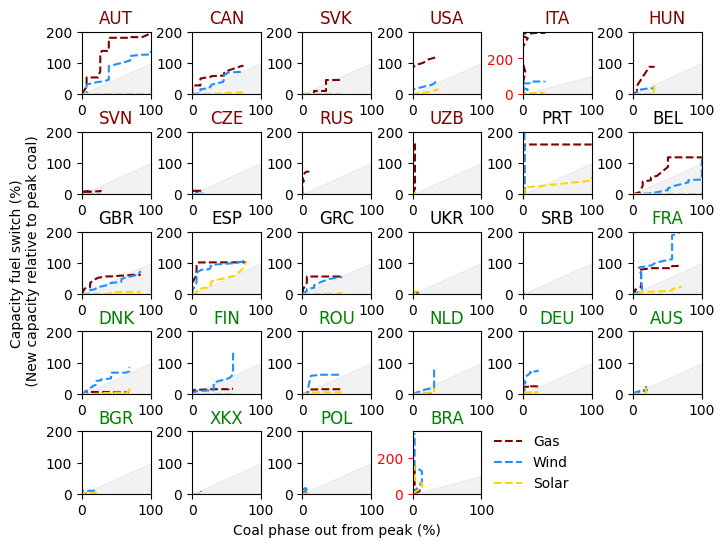

In [92]:
fig, axes = plt.subplots(5,6,figsize=(8,6))
fig.subplots_adjust(wspace=0.6,hspace=0.6)
unique_countries = list(selected_data_all["Country Code"].unique())
points = [[100, 100], [100, 0], [0, 0]]
triangle = np.array(points + points[:1])
for cntry in all_country_list:
    n_ind = all_country_list.index(cntry)
    plot_data = selected_data_all[selected_data_all["Country Code"]==cntry]
    this_ax = axes.flatten()[n_ind]
    this_ax.fill(triangle[:, 0], triangle[:, 1], color='gray', alpha=0.1)
    this_ax.plot(plot_data["Coal_Share_PhasedOut"],plot_data["Gas_FuelSwitch"], '-',markerfacecolor="none",color="maroon",ls="dashed",label="Gas")
    this_ax.plot(plot_data["Coal_Share_PhasedOut"],plot_data["Wind_FuelSwitch"], '-',markerfacecolor="none",color="dodgerblue",ls="dashed",label="Wind")
    this_ax.plot(plot_data["Coal_Share_PhasedOut"],plot_data["Solar_FuelSwitch"], '-',markerfacecolor="none",color="gold",ls="dashed",label="Solar")
    #this_ax.plot(plot_data["Year"],plot_data["Coal_Share_PhasedOut"], '-o',ls="dashed")
    this_ax.set_title(cntry)
    if cntry in more_gas_list:
        this_ax.title.set_color('maroon')
    elif cntry in more_re_list:
        this_ax.title.set_color('green')
    this_ax.set_xlim([0,100])
    if cntry in ["ITA","BRA"]:
        this_ax.set_ylim([0,350])
        this_ax.tick_params(axis='y', colors='red')
    else:
        this_ax.set_ylim([0,200])
this_ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),frameon=False)
axes.flatten()[-1].remove()
axes.flatten()[-2].remove()
axes[2,0].set_ylabel("Capacity fuel switch (%)\n (New capacity relative to peak coal)")
axes[4,2].set_xlabel("Coal phase out from peak (%)")

Text(0.5, 0, 'Coal phase out from peak (%)')

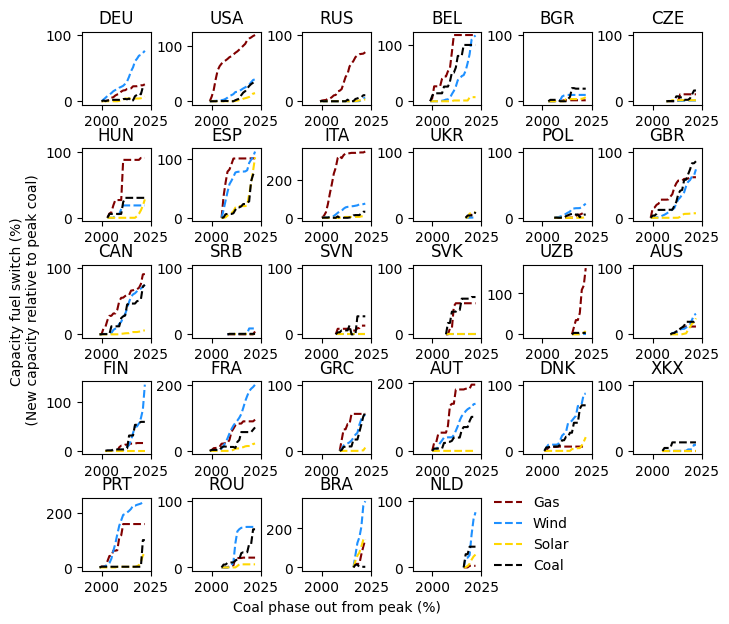

In [93]:
fig, axes = plt.subplots(5,6,figsize=(8,7))
fig.subplots_adjust(wspace=0.6,hspace=0.6)
unique_countries = list(selected_data_all["Country Code"].unique())
points = [[100, 100], [100, 0], [0, 0]]
triangle = np.array(points + points[:1])
for cntry in unique_countries:
    n_ind = unique_countries.index(cntry)
    plot_data = selected_data_all[selected_data_all["Country Code"]==cntry]
    this_ax = axes.flatten()[n_ind]
    this_ax.fill(triangle[:, 0], triangle[:, 1], color='gray', alpha=0.1)
    this_ax.plot(plot_data["Year"],plot_data["Gas_FuelSwitch"], '-',markerfacecolor="none",color="maroon",ls="dashed",label="Gas")
    this_ax.plot(plot_data["Year"],plot_data["Wind_FuelSwitch"], '-',markerfacecolor="none",color="dodgerblue",ls="dashed",label="Wind")
    this_ax.plot(plot_data["Year"],plot_data["Solar_FuelSwitch"], '-',markerfacecolor="none",color="gold",ls="dashed",label="Solar")
    this_ax.plot(plot_data["Year"],plot_data["Coal_Share_PhasedOut"], '-',markerfacecolor="none",color="black",ls="dashed",label="Coal")
    #this_ax.plot(plot_data["Year"],plot_data["Coal_Share_PhasedOut"], '-o',ls="dashed")
    this_ax.set_title(cntry)
    this_ax.set_xlim([1990,2025])
    #if cntry in ["ITA","BRA"]:
    #    this_ax.set_ylim([0,350])
    #    this_ax.tick_params(axis='y', colors='red')
    #else:
    #    this_ax.set_ylim([0,200])
this_ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),frameon=False)
axes.flatten()[-1].remove()
axes.flatten()[-2].remove()
axes[2,0].set_ylabel("Capacity fuel switch (%)\n (New capacity relative to peak coal)")
axes[4,2].set_xlabel("Coal phase out from peak (%)")